## Import

In [1]:
import os
from os.path import dirname
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import scipy.stats as stats
import seaborn as sns


sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'


## color and saving

In [2]:
color = "#9a3324"

cmap_color_end = "#00274C"
cmap_color_start = "#FFCB05"
cmap_name = "maize2blue"

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig2_diffusion analysis/multi_stage_diffusion_examples"
os.chdir(folder_save)


## Prepare track

In [3]:
df = pd.read_csv("SPT_results_AIO_concat-multistage examples.csv")
idx = 0


In [4]:
nm_per_pxl = 117
um_per_pixel = 0.117
s_per_frame = 0.02

x = np.fromstring(df.iloc[idx]["list_of_x"][1:-1], sep=", ")
y = np.fromstring(df.iloc[idx]["list_of_y"][1:-1], sep=", ")
t = np.fromstring(df.iloc[idx]["list_of_t"][1:-1], sep=", ")
MSD = np.fromstring(df.iloc[idx]["list_of_MSD_um2"][1:-1], sep=", ")
tau = np.fromstring(df.iloc[idx]["list_of_tau_s"][1:-1], sep=", ")
x = (x - (x.min() + x.max()) / 2) * nm_per_pxl
y = (y - (y.min() + y.max()) / 2) * nm_per_pxl
t = (t - t[0]) * s_per_frame

df_track = pd.DataFrame(
    {
        "t": (t / s_per_frame).astype(int),
        "x": (x / nm_per_pxl).astype(float),
        "y": (y / nm_per_pxl).astype(float),
    }
)

## Plot RNA track

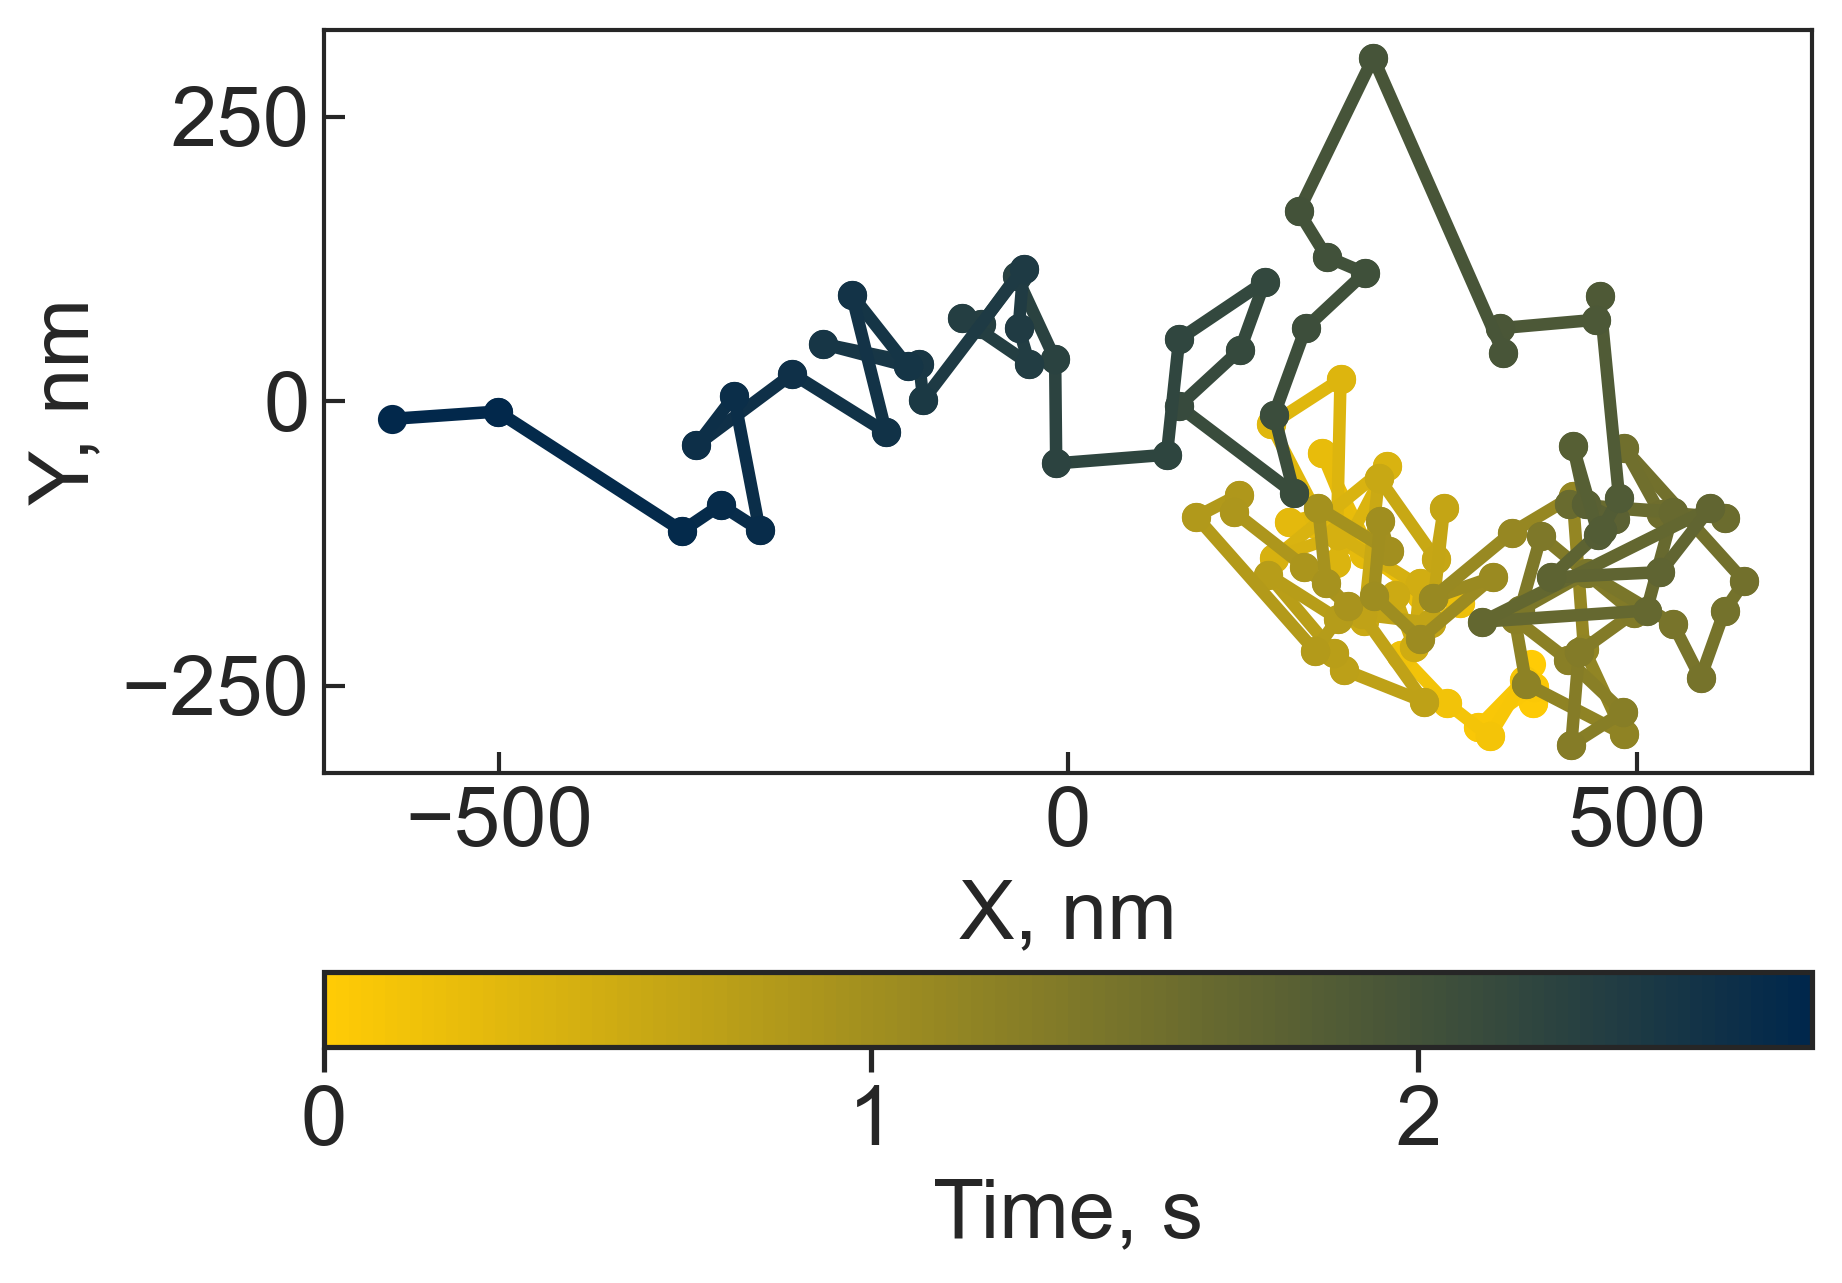

In [13]:
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name, [cmap_color_start, cmap_color_end], N=x.shape[0]
)

# Adjust track
t_plot = t
x_plot = x - (x.min() + x.max()) / 2
y_plot = -(y - (y.min() + y.max()) / 2)
# y_plot = -(x - (x.min() + x.max()) / 2)
# x_plot = -(y - (y.min() + y.max()) / 2)

fig = plt.figure()
for i in range(len(t_plot) - 1):
    plt.plot(
        x_plot[i : i + 2],
        y_plot[i : i + 2],
        "-o",
        color=cmap(i / len(t_plot)),
        linewidth=3,
    )

# tick number and sizes
plt.gca().axis("equal")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=20,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

# xy_max = np.max([x_plot.max(), y_plot.max()])
# plt.gca().set_xlim(-xy_max, xy_max)
# plt.gca().set_ylim(-xy_max, xy_max)
plt.gca().xaxis.set_major_locator(MaxNLocator(3))
plt.gca().yaxis.set_major_locator(MaxNLocator(3))


# color bar
cbar = plt.colorbar(
    cm.ScalarMappable(norm=clr.Normalize(t[0], t[-1]), cmap=cmap),
    ax=plt.gca(),
    orientation="horizontal",
    pad=0.18,
    drawedges=False,
)
cbar.set_label(label="Time, s", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.xlabel("X, nm", fontsize=20)
plt.ylabel("Y, nm", fontsize=20)


# saving
plt.savefig(
    fname_save_prefix + "-track.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


## Running window analysis

In [5]:
def calc_MSD_NonPhysUnit(df_track, lags):
    df_track_sorted = df_track.sort_values("t")
    # prepare storage arrays
    MSDs = []
    # STDs = np.array([], dtype=float)

    # filling gaps
    ref_t = list(range(df_track_sorted.t.min(), df_track_sorted.t.max()))
    missing_t = list(set(ref_t) - set(df_track_sorted.t))
    if len(missing_t) > 0:
        for t in missing_t:
            complete_t = np.append(df_track_sorted.t, np.array(missing_t, dtype=int))
            complete_x = np.append(df_track_sorted.x, np.repeat(np.NaN, len(missing_t)))
            complete_y = np.append(df_track_sorted.y, np.repeat(np.NaN, len(missing_t)))
            df_complete = pd.DataFrame()
            df_complete["x"] = complete_x
            df_complete["y"] = complete_y
            df_complete["t"] = complete_t
            df_complete = df_complete.sort_values("t")

    else:
        df_complete = df_track_sorted

    # calculate MSDs corresponding to a series of lag times
    for lag in lags:
        Xs = np.array(df_complete.x, dtype=float)
        Ys = np.array(df_complete.y, dtype=float)

        SquareDisplacements = (Xs[lag:] - Xs[:-lag]) ** 2 + (Ys[lag:] - Ys[:-lag]) ** 2
        MSD = np.nanmean(SquareDisplacements)
        MSDs.append(MSD)

    MSDs = np.array(MSDs, dtype=float)
    return MSDs

In [7]:
window_size = 20
lags = np.linspace(1, window_size, window_size).astype(int)
lst_t_start = []
lst_log10D = []
lst_alpha = []
# Set a minimal for how many datapoints needed to calculate the last MSD value (of the largest lag)
minimal_datapoints = 5
for i in range(df_track.shape[0] - lags.shape[0] - minimal_datapoints):
    MSDs = calc_MSD_NonPhysUnit(
        df_track.iloc[i : i + lags.shape[0] + minimal_datapoints], lags
    )
    if np.isnan(MSDs).any():
        print(i)
    lags_phys = lags * s_per_frame
    MSDs_phys = MSDs * (um_per_pixel**2)
    slope_linear, intercept_linear, R_linear, P, std_err = stats.linregress(
        lags_phys, MSDs_phys
    )
    D_phys_linear = slope_linear / (8 / 3)  # um^2/s
    slope_loglog, intercept_loglog, R_loglog, P, std_err = stats.linregress(
        np.log10(lags_phys),
        np.log10(MSDs_phys),
    )
    log10D_loglog = intercept_loglog - np.log10(4)
    alpha = slope_loglog

    lst_t_start.append(df_track.iloc[i : i + lags.shape[0]]["t"].mean() * s_per_frame)
    lst_log10D.append(D_phys_linear)
    lst_alpha.append(alpha)

arr_t_start = np.array(lst_t_start, dtype=float)
arr_t_start = arr_t_start - arr_t_start[0]
arr_log10D = np.array(lst_log10D, dtype=float)
arr_alpha = np.array(lst_alpha, dtype=float)

In [88]:
# Plot log10D linear
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(arr_t_start, arr_log10D, lw=3, c="#9a3324")
plt.xlabel("Time, s", fontsize=15)
plt.ylabel(r"D$_{app}$, $\mu$m$^2$/s", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlim(
    arr_t_start[0],
    arr_t_start[-1],
)
plt.savefig(
    "running_window_log10D-" + str(idx) + "-lag-" + str(lags.shape[0]) + ".png",
    format="png",
    bbox_inches="tight",
)
plt.close()
# Plot alpha component
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(arr_t_start, arr_alpha, lw=3, c="#9a3324")
plt.xlabel("Time, s", fontsize=15)
plt.ylabel(r"$\alpha$ component", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlim(
    arr_t_start[0],
    arr_t_start[-1],
)
plt.savefig(
    "running_window_alhpa-" + str(idx) + "-lag-" + str(lags.shape[0]) + ".png",
    format="png",
    bbox_inches="tight",
)
plt.close()

## HMM analysis

In [69]:
from hmmlearn import hmm


def hmm_predict(data):
    # data = arr_log10D.reshape(-1, 1)
    converged = False
    while not converged:
        model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=10000)
        model.fit(data)
        converged = model.monitor_.converged

    print(
        "Model converged!",
        str(model.monitor_.converged),
        ", Score is",
        model.score(data),
    )
    hmm_result = model.predict(data)
    return hmm_result

In [71]:
hmm_log10D = hmm_predict(arr_log10D.reshape(-1, 1))
hmm_alpha = hmm_predict(arr_alpha.reshape(-1, 1))

Model converged! True , Score is 239.7140732885526
Model converged! True , Score is 58.52335974611752


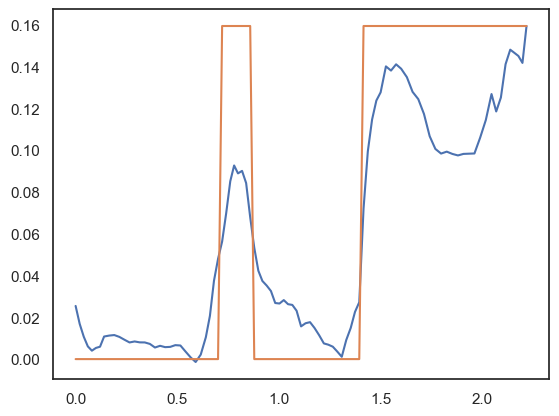

In [74]:
plt.plot(arr_t_start, arr_log10D)
plt.plot(arr_t_start, (1-hmm_log10D)*arr_log10D.max())

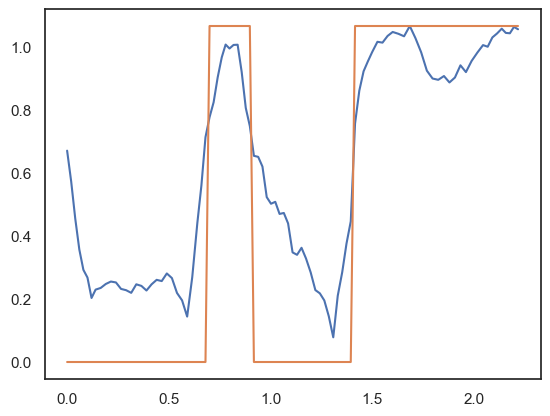

In [75]:
plt.plot(arr_t_start, arr_alpha)
plt.plot(arr_t_start, hmm_alpha*arr_alpha.max())

In [86]:
# implement a clear transition mid point between each transition
hmm_t_log10D = []
hmm_log10D_fixed = []
state_before = hmm_log10D[0]
for t, state in zip(arr_t_start, hmm_log10D):
    if state != state_before:
        hmm_t_log10D.append(t)
        hmm_log10D_fixed.append(state_before)
        hmm_t_log10D.append(t)
        hmm_log10D_fixed.append(state)
    else:
        hmm_t_log10D.append(t)
        hmm_log10D_fixed.append(state)
    state_before = state
hmm_t_log10D = np.array(hmm_t_log10D, float)
hmm_log10D_fixed = np.array(hmm_log10D_fixed, float)

hmm_t_alpha = []
hmm_alpha_fixed = []
state_before = hmm_alpha[0]
for t, state in zip(arr_t_start, hmm_alpha):
    if state != state_before:
        hmm_t_alpha.append(t)
        hmm_alpha_fixed.append(state_before)
        hmm_t_alpha.append(t)
        hmm_alpha_fixed.append(state)
    else:
        hmm_t_alpha.append(t)
        hmm_alpha_fixed.append(state)
    state_before = state
hmm_t_alpha = np.array(hmm_t_alpha, float)
hmm_alpha_fixed = np.array(hmm_alpha_fixed, float)

In [89]:
# Plot log10D linear with hmm
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(arr_t_start, arr_log10D, lw=3, c="#9a3324")
hmm_min_toplot = arr_log10D.max() * 1.05
hmm_delta_toplot = np.ptp(arr_log10D) * 0.2
hmm_toplot = hmm_min_toplot + hmm_delta_toplot * (1 - hmm_log10D_fixed)
plt.plot(hmm_t_log10D, hmm_toplot, lw=3, c="black")
plt.xlabel("Time, s", fontsize=15)
plt.ylabel(r"D$_{app}$, $\mu$m$^2$/s", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlim(
    arr_t_start[0],
    arr_t_start[-1],
)
plt.savefig(
    "running_window_log10D_hmm-" + str(idx) + "-lag-" + str(lags.shape[0]) + ".png",
    format="png",
    bbox_inches="tight",
)
plt.close()
# Plot alpha component with hmm
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(arr_t_start, arr_alpha, lw=3, c="#9a3324")
hmm_min_toplot = arr_alpha.max() * 1.05
hmm_delta_toplot = np.ptp(arr_alpha) * 0.2
hmm_toplot = hmm_min_toplot + hmm_delta_toplot * hmm_alpha_fixed
plt.plot(hmm_t_alpha, hmm_toplot, lw=3, c="black")
plt.xlabel("Time, s", fontsize=15)
plt.ylabel(r"$\alpha$ component", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlim(
    arr_t_start[0],
    arr_t_start[-1],
)
plt.savefig(
    "running_window_alhpa_hmm-" + str(idx) + "-lag-" + str(lags.shape[0]) + ".png",
    format="png",
    bbox_inches="tight",
)
plt.close()

In [76]:
np.ptp(arr_log10D)

0.16084034023686863

In [77]:
arr_log10D.max()-arr_log10D.min()

0.16084034023686863